
# LAB: **IMAGE SEGMENTATION**



---

***STUDENT(S):  José Lorente López - DNI:48842308Z*** 

---


**Image segmentation** is a method in which a digital image is broken down into various subgroups called *Image segments* which helps in reducing the complexity of the image to make further processing or analysis of the image simpler. **Segmentation in easy words is assigning labels to pixels.** All picture elements or pixels belonging to the same category have a common label assigned to them. **For example**: Let’s take a problem where the picture has to be provided as input for object detection. Rather than processing the whole image, the detector can be inputted with a region selected by a segmentation algorithm. This will prevent the detector from processing the whole image thereby reducing inference time.
<figure>
<center><img src="https://vladlen.info/wp-content/uploads/FSO-1.jpg" width="60%"></center> 
<figcaption align = "center"> Image segmentation example. </figcaption>
</figure>


# Approaches in Image Segmentation

*   *Similarity approach*: This approach is based on detecting similarity between image pixels to form a segment, based on a threshold. ML algorithms like clustering are based on this type of approach to segment an image.
*   *Discontinuity approach*: This approach relies on the discontinuity of pixel intensity values of the image. Line, Point, and Edge Detection techniques use this type of approach for obtaining intermediate segmentation results which can be later processed to obtain the final segmented image.

# Image Segmentation Techniques

*   Threshold Based Segmentation
*   Edge Based Segmentation
*   Region-Based Segmentation
*   Clustering Based Segmentation
*   **Artificial Neural Network Based Segmentation**

In this lab we will focus on **Artificial Neural Network Based Segmentation** using **U-Net architecture**.

# U-Net

U-Net, named for its U-shape, was originally created in 2015 for tumor detection, but in the years since has become a very popular choice for other **semantic segmentation tasks**.

U-Net builds on a previous architecture called the **Fully Convolutional Network (FCN)** which replaces the dense layers found in a typical CNN with a transposed convolution layer that upsamples the feature map back to the size of the original input image, while preserving the spatial information. This is necessary because the dense layers destroy spatial information (the "where" of the image), which is an essential part of image segmentation tasks. An added bonus of using transpose convolutions is that **the input size no longer needs to be fixed**, as it does when dense layers are used.

Unfortunately, **the final feature layer of the FCN suffers from information loss due to downsampling too much**. It then becomes difficult to upsample after so much information has been lost, causing an output that looks rough.

<figure>
<center><img src="https://miro.medium.com/max/640/1*NXNGhfSyzQcKzoOSt-Z0Ng.webp" width="60%"></center> 
<figcaption align = "center"> FCN architecture. </figcaption>
</figure>


**U-Net improves on the FCN**. Instead of one transposed convolution at the end of the network, it uses a matching number of convolutions for downsampling the input image to a feature map, and transposed convolutions for upsampling those maps back up to the original input image size. It also adds **skip connections**, to retain information that would otherwise become lost during encoding. Skip connections send information to every upsampling layer in the decoder from the corresponding downsampling layer in the encoder, capturing finer information while also keeping computation low. These help prevent information loss, as well as model overfitting.

<figure>
<center><img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png" width="70%"></center> 
<figcaption align = "center"> U-Net architecture. </figcaption>
</figure>






El proceso de segmentar una imágen consiste en dividirla en subgrupos (segmentos de imágen) que simplifica el análisis de la misma. Estos segmentos de imágen serán etiquetados con un label (entre los posibles que tengamos) (en función del objeto dentro de la imágen al que pertenezca dicho píxel) y acada label se le dará un color; dejando la imágen como un segmentation map tal y como se ve arriba.

Esto es útil para reducir gasto computacional en, por ejemplo, un problema en el que debemos proporcionar una imagen como entrada para la detección de objetos. En vez de introducir la imágen al completo (y tener que procesarla entera), se puede introducir una de las regiones seleccionadas por el algoritmo de segmentación y reducir el coste.

La segmentación se aplica de dos formas diferentes:

    - Con la similitud etre píxeles adyacentes y así ir formando un segmento (se entiende que ya no guardan similitud a través de un threshold). Para hacer esto se aplica algoritmo de ML de clustering (si tenemos 10 posibles labels, aplico un cluster de 10 grupos y divido así en segmentos).

    - Con discontinuidades: cambios bruscos de valores entre píxeles de una imagen y realizamos los segmentos a través de la detección de líneas, puntos y bordes. 

Se puede segmentar con thresholds, bordes de la imagen, regiones, clusteros o con RN. Nos centraremos en la segmentación usando redes neuronales (dato:imagen, label:segmentation map) recurriendo a la arquitectura U-Net.

Red en forma de "U" CNN (FCN - Red completamente convolucional), con arquitectura encoder (capas convolucionales) + decorder (capas convolucionales transpuestas) (de forma que segmentamos la imágen y tenemos (como obviamente necesitamos) entrada y salida de un tamaño igual). Cabe destacar que la U-Net en lugar de una convolución trasnpuesta al final de la red, usa un número equivalente de convoluciones para reducir la imagen de entrada y transpuestas. Una última característica de la U-NET es que añaden "conexiones de salto". Estas conexiones consisten en enviar información de cada capa del encoder a su capa equivalente en el decoder lo que permite retener información que, de otro modo, se perdería durante la codificación. (Y evitar overfitting y reducir el número de cálculos).



# Dataset

In this lab we will use [**Cityscapes**](https://www.cityscapes-dataset.com/) **Image Pairs dataset**. It contains labeled videos taken from vehicles driven in Germany. This version is a processed subsample created as part of the [Pix2Pix](https://phillipi.github.io/pix2pix/) paper. The dataset has still images from the original videos, and the semantic segmentation labels are shown in images alongside the original image. This is one of the best datasets around for semantic segmentation tasks.

This dataset has 2975 training images files and 500 validation image files. Each image file is 256x512 pixels, and each file is a composite with the original photo on the left half of the image, alongside the labeled image (output of semantic segmentation) on the right half.



Utilizaremos el dataset Cityscapes que tienen frames de un video de coches conduciendo por alemania (fotos de calles y peatones, básicamente). La imagen se divide por la mitad, la parte izquierda es la imagen original y la derecha es su label (su segmentation map).

Contamos con 2975 imágenes de entrenamiento y 500 imágenes de validación. Cada imágen es de 256x512 (por lo que la imagen y el label son de 256x256).

# Imports


In [1]:
# Importamos las librerías necesarias para el desarrollo de la práctica

import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


from tqdm.notebook import tqdm

%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

d:\anaconda\envs\ids\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\anaconda\envs\ids\lib\site-packages\requests\__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


# PART I: Loading Cityscapes dataset

First, import to your own Drive the folder I shared with you in Aula Global.

Importamos las direcciones de los datos de train y validation:

In [2]:
# UPDATE THIS ACCORDING TO YOUR PATH!
path_to_folder = 'D:/Escritorio/Master - CIII/1ºCuatrimestre/2ºSemicuatrimestre/Códigos - Python/Aprendizaje Profundo/Practica3/Cityscapes/cityscapes_data/'

# Direcciones de los datos de entrenamiento y validación
train_dir = os.path.join(path_to_folder, "train") 
test_dir = os.path.join(path_to_folder, "val")

# Lista con las imagenes/datos del conjunto de entrenamiento y validación
train_fns = os.listdir(train_dir)
test_fns = os.listdir(test_dir)

# Veamos la cantidad de datos de train y val con los que contamos
print('We have %d train images.' %len(train_fns))
print('We have %d test images.' %len(test_fns))


We have 2975 train images.
We have 500 test images.


Visualize one image from Cityscapes

Hagamos el plot de una imagen (por ejemplo la primera de entrenamiento) y veamos como la primera mitad es la imagen original y la segunda es el segmentation map:

D:/Escritorio/Master - CIII/1ºCuatrimestre/2ºSemicuatrimestre/Códigos - Python/Aprendizaje Profundo/Practica3/Cityscapes/cityscapes_data/train\1.jpg


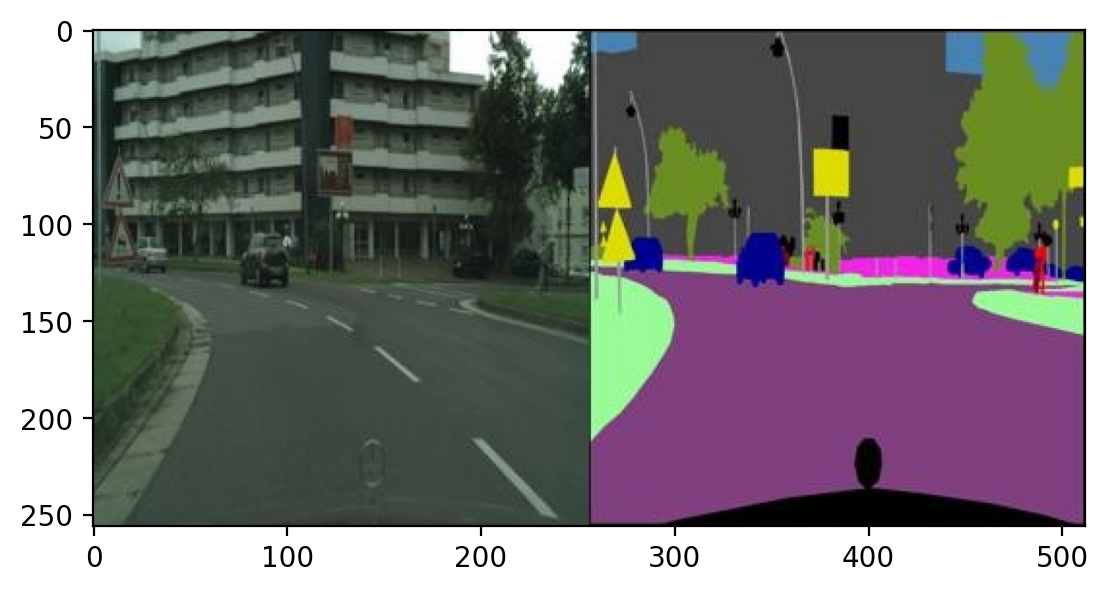

In [3]:
sample_image_fp = os.path.join(train_dir, train_fns[0]) # Con esto tomamos la dirección completa (dir_datos + dir_primera_imagen_train)
sample_image = Image.open(sample_image_fp).convert("RGB") # Abrimos la imagen directamente en este objeto en color_map RGB
plt.imshow(sample_image) # Ponemos la imagen con labels (nºpixel tanto en x(ancho) como en y(alto) + RGB (3 capas))
print(sample_image_fp) # Vemos la dirección de la imagen ploteada

# PART II: Extracting Image and Labels
The input images contain both the road scene and the corresponding label in the same image. Thus, we are splitting it and presenting it as two separate entities.

Hagamos una función que separe una imagen en la imagen por un lado y el label (segmentation map) por otro:

In [4]:
def split_image(image):
  image = np.array(image) # Si aplico np.array() a la imagen abierta, obtengo sus valores numéricos (3x(256x256))
  cityscape, label = image[:, :256, :], image[:, 256:, :] # Dividimos tomando la mitad de la anchura por un lado y la otra mitad por el otro (label)
  return cityscape, label

Apliquemos la función a la primera imagen del dataset

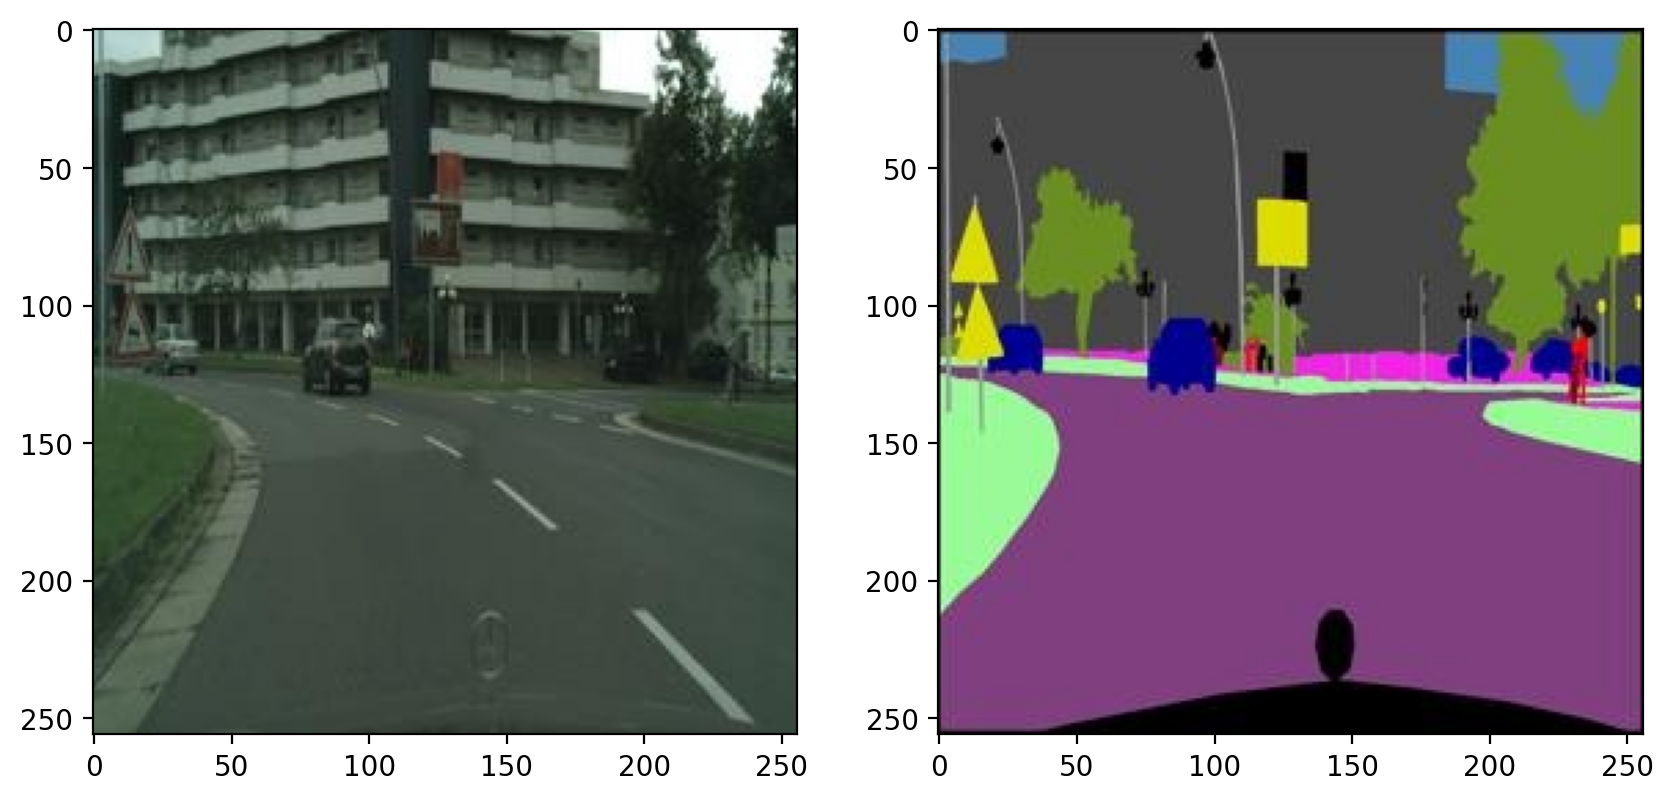

In [5]:
sample_image = np.array(sample_image) # no es necesario ya que se hace en la propia función
cityscape, label = split_image(sample_image) # obtenbemos la imagen

# display split images
cityscape, label = Image.fromarray(cityscape), Image.fromarray(label) # pasamos del array (que es lo que da la función), a la imagen como tal para plotearla
fig, axes = plt.subplots(1, 2, figsize=(10,5))

# Vemos como cada imagen es de 256x256
axes[0].imshow(cityscape)
axes[1].imshow(label)

Las labels deben transformarse de una imagen RGB (3 valores diferentes) a una matriz de etiquetas (solo 1 valor, 1 canal). Cada valor (de los 256x256) RGB (con 3 capas) se transforma (en función de su valor RGB) en una de las etiquetas (tendremos 10 posibles por lo que tomará un valor de 0 a 9 en función de la etiqueta que se le asigne a ese píxel por el objeto al que se le asocie).

Esto se puede hacer o con noseq (nos da igual) o con un K-means. En nuestro caso lo haremos con un K-means.

Generaremos un conjunto (grande) de valores RGB, lo meteremos al K-means y haremos que este cree sus grupos. Una vez se haya entrenado, al introducir cada píxel de la imagen original al modelo, este se etiquetará entre una de las clases y eso dará paso al segmentation map.

En nuestro conjunto de entrenamiento, tenemos 10 posibles objetos en las imágenes (por eso dividimos los datos RGB en 10 posibles clases para etiquetarlos). Según la clase se plotea con un color y creamos el "segmnentation map".

We need to transform the RGB label image (3 channels) to a label matrix (1 channel). For this, we have two options:

1.   Define a dictionary that maps RGB values to class labels.
2.   Train a clustering model (as K-Means) to assign class labels to RGB values automatically.


Let's try the second option to spice up things a little!

> **Exercise**: Complete the following code.


El conjunto de entrenamiento para el K-means sera 5000 valores (donde, cada valor son un conjunto de 3 datos representando un dato RGB). Con esto haremos que el K-means cree 10 clases diferentes.

In [6]:
# Define random RGB images
num_items = 5000
color_array = np.random.choice(range(256), 3*num_items).reshape(-1,3)
print(color_array.shape)

(5000, 3)


In [7]:
color_array[0] # Veamos un dato de entrenamiento cualquiera (3 valores que forma un dato RGB)

array([ 28, 171, 179])

In [8]:
from sklearn.cluster import KMeans

In [9]:
# Learn how to cluster all the colors in num_classes
num_classes = 10
label_model = KMeans(n_clusters=num_classes) # Creamos un KMeans con 10 clases
label_model.fit(color_array) # Los entrenamos con los datos RGB obtenidos aleatoriamente

KMeans(n_clusters=10)

Probemos el modelo con la primera imagen de entrenamiento:

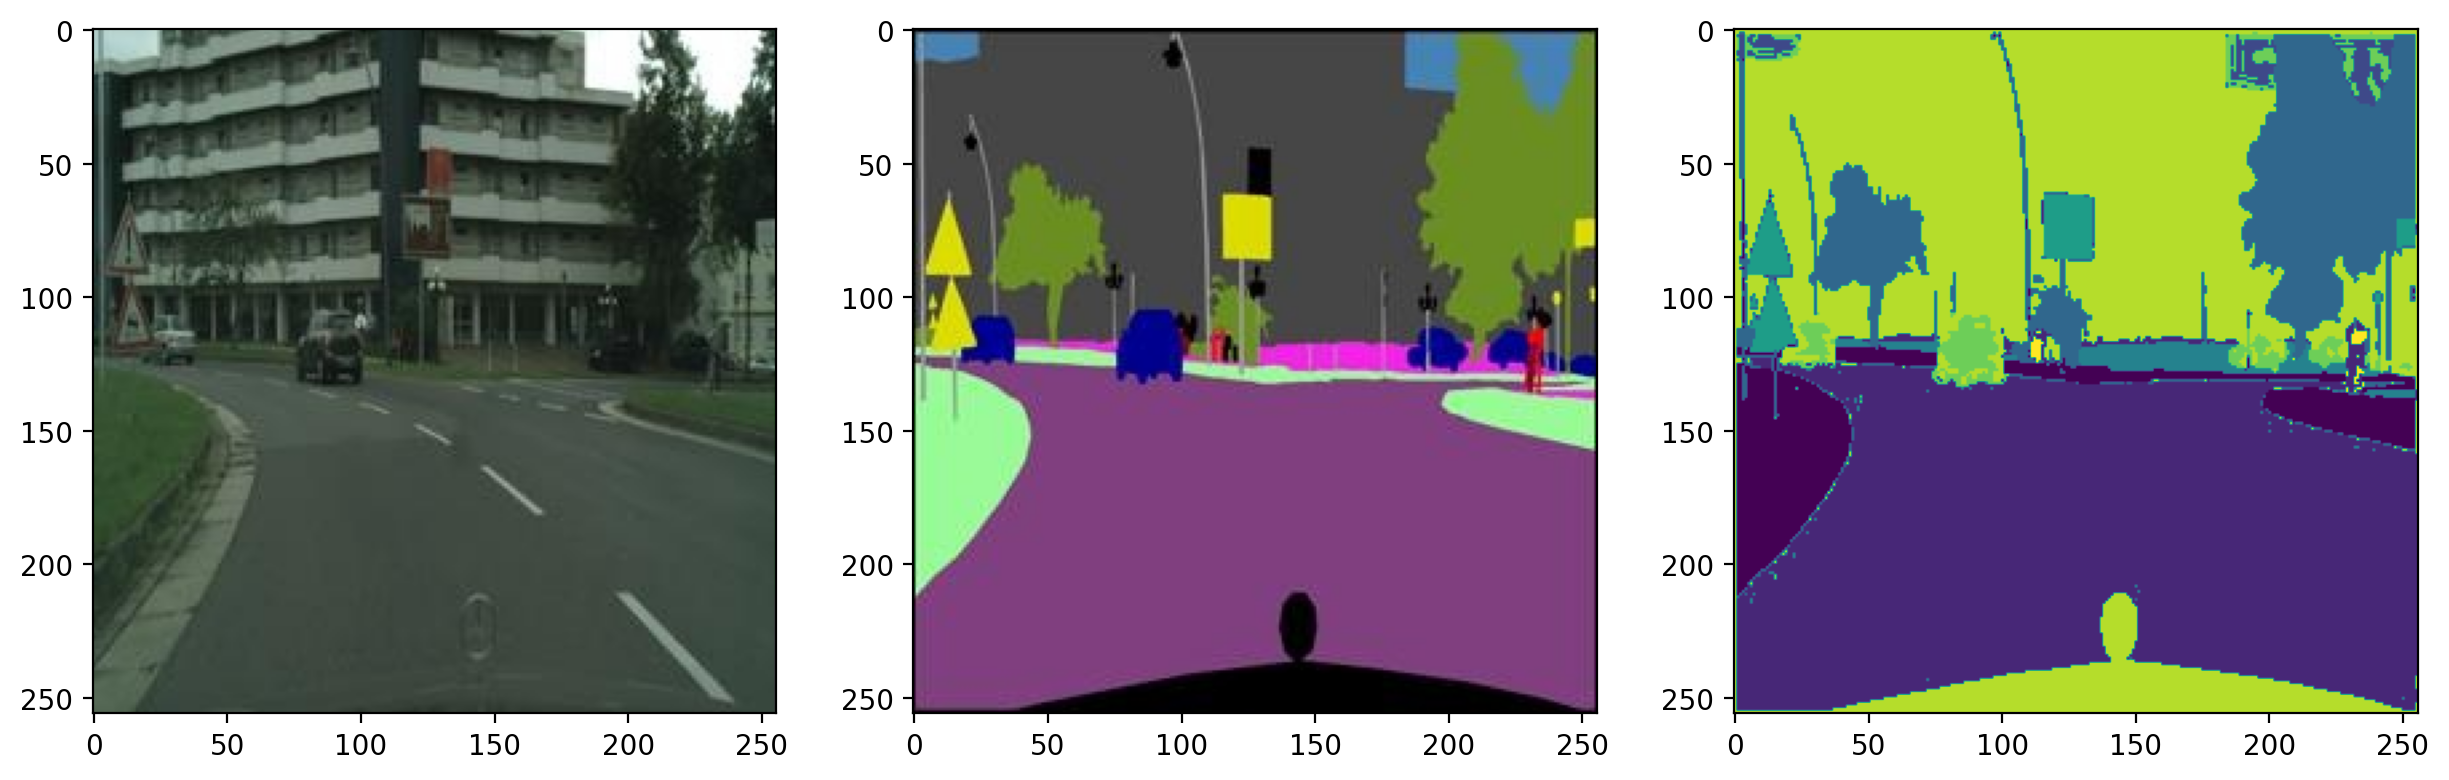

In [10]:
cityscape, label = split_image(sample_image)
label_class = label_model.predict(label.reshape(-1,3)).reshape(256,256) # Usamos el KMeans para crear el segmentation map
fig, axes = plt.subplots(1,3,figsize=(15,5))

# Ploteamos la imagen original, el label y el segmentation map
axes[0].imshow(cityscape)
axes[1].imshow(label)
axes[2].imshow(label_class)

Como vemos, se han creado 10 clases diferentes capaces de segmentar bien los diferentes objetos que encontramos en las imágenes. A cada imágen se le ha puesto uno de los 10 diferentes labels y entiende bien objetos diferentes e iguales.

Dado el modelo sin entrenar, vemos como usando el segmentation map como entrada, el modelo es capaz facilmente de reconocer los diferentes objetos (lo cual es lógico ya que el mapa como tal ya está creado).

Now we define a Dataset for this data. In the transformations we reduce the size of the images to speed up training.

In [11]:
class CityscapeDataset(Dataset):

  def __init__(self, image_dir, label_model): # Introducimos la dirección en el PC de los datos y el modelo de cluster de los píxeles en las clases

    self.image_dir = image_dir
    self.image_fns = os.listdir(image_dir)
    self.label_model = label_model

  def __len__(self):
    return len(self.image_fns)
  
  def __getitem__(self, index): # Con esto obtenemos (imagen original normalizada y label normalizado en forma de segmentation map)

    # Get the image from the root directory
    image_fn = self.image_fns[index]
    image_fp = os.path.join(self.image_dir, image_fn)
    image = Image.open(image_fp).convert("RGB")
    image = np.array(image)

    # Split in image and labels
    cityscape, label = self.split_image(image)

    # Extract and transform label matrix
    label = np.array(self.transform_lab(Image.fromarray(label)))
    label_class = self.label_model.predict(label.reshape(-1,3)).reshape(64,64)
    label_class = torch.Tensor(label_class).long()

    # Transform image
    cityscape = self.transform_img(Image.fromarray(cityscape))

    return cityscape, label_class

  def split_image(self, image): # Función para separar imagen de segmentation map

    image = np.array(image)
    cityscape, label = image[:, :256, :], image[:, 256:, :]

    return cityscape, label
  

  # Funciones para normalizar (y redecuri a un tamaño de 64x64) las imagenes y los labels con el fin de reducir el tamaño de estas y mejorar el coste computacional

  def transform_img(self, image):

    transform_ops = torchvision.transforms.Compose([
                                        torchvision.transforms.Resize((64, 64)),
                                        torchvision.transforms.ToTensor(),
                                        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    return transform_ops(image)

  def transform_lab(self, image):

    transform_ops = torchvision.transforms.Compose([
                                        torchvision.transforms.Resize((64, 64))
    ])

    return transform_ops(image)

> **Exercise**: complete the following code to create a dataset for training data and another one for test data. Show an example (image and its segmentation) from the train dataset.

Creamos las direcciones para train y test con el modelo creado:

In [12]:
dataset_train = CityscapeDataset(train_dir, label_model)
dataset_test = CityscapeDataset(test_dir, label_model)

Ej de una imagen cualquiera de train:

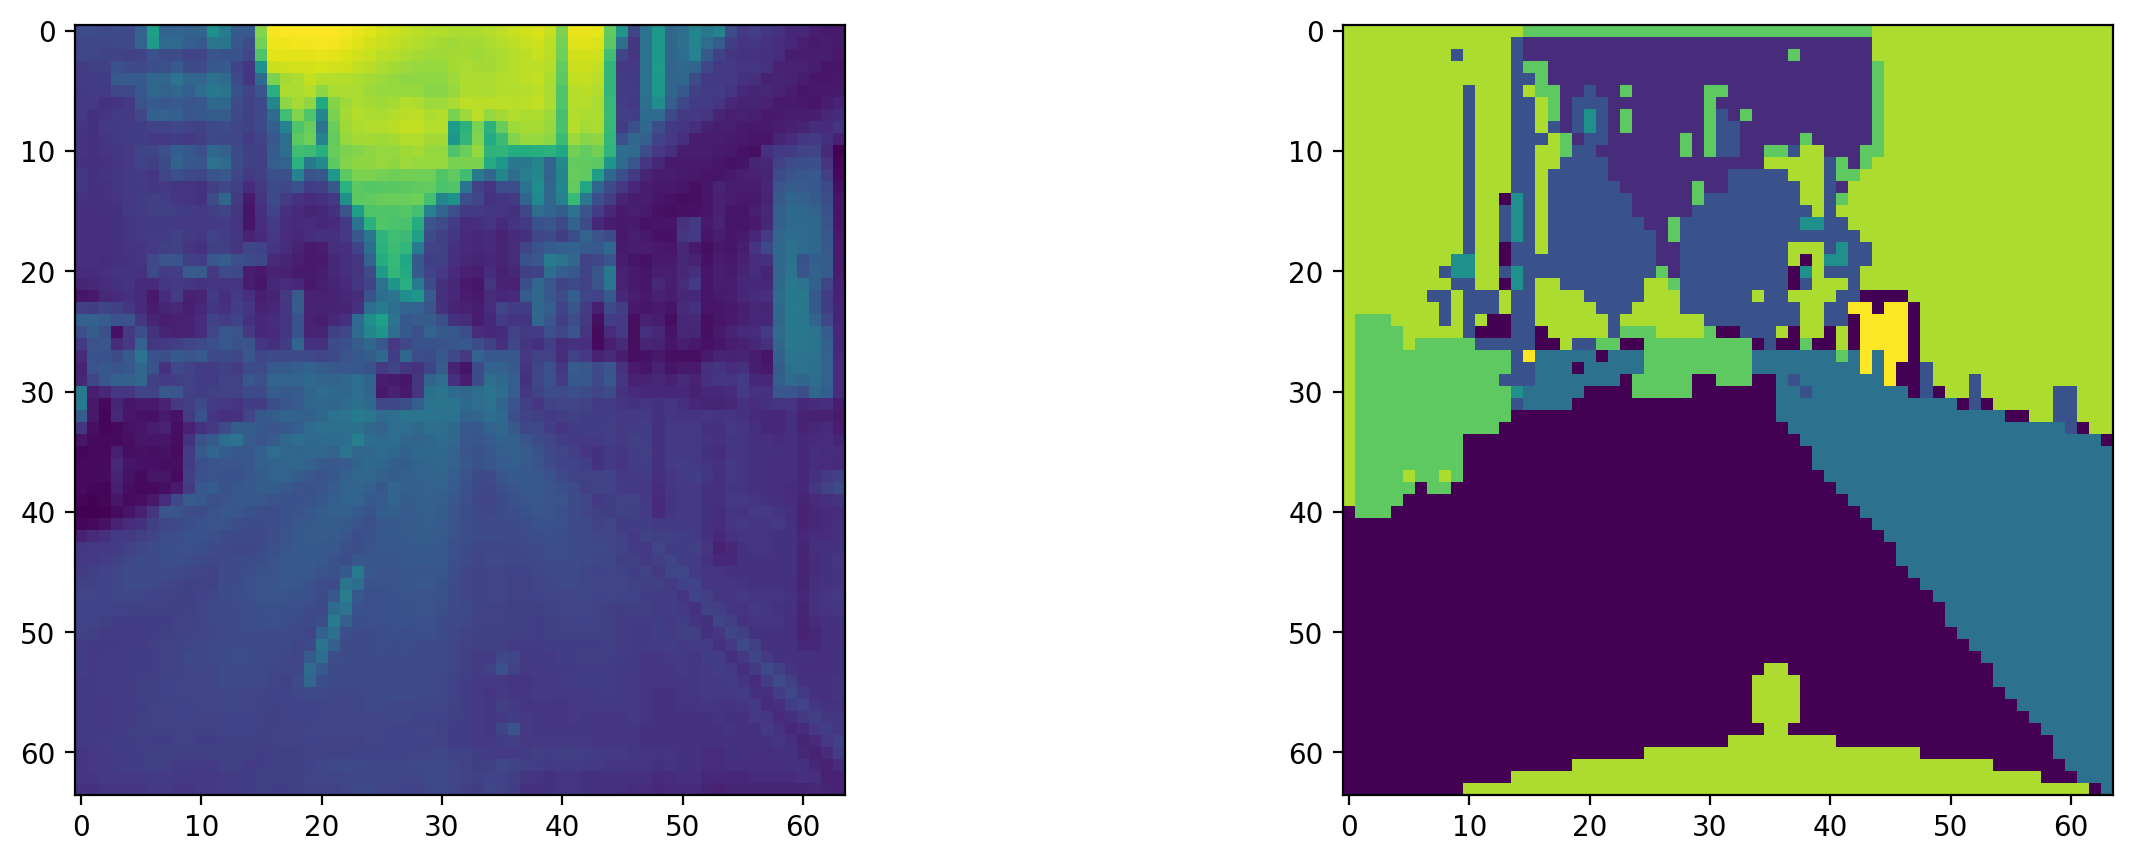

In [13]:
imagen_5_train, label_5_train = dataset_train.__getitem__(5) # Esta es la función que toma la imagen que le indiques, la divbide en imagen y label, aplica las transformaciones...

fig, axes = plt.subplots(1,2,figsize=(15,5))
axes[0].imshow(np.array(imagen_5_train[0]))
axes[1].imshow(label_5_train)

He puesto una capa RGB solo en la imagen original para notar más aún los objetos y sus diferencias.

Lógicamente tanto la imagen original como el label se ven sustancialmente peor en comparación al plot de las imágenes originales y obtenidas por el modelo de arriba. Esto es porque con el metodo __getitem__ las imágenes se normalizan y se reducen a un tamaño de 64x64 para reducir el coste computacional y al plotearlas se ven peor.

Let's show an example from our defined dataset. We define a method to visualize the images, as they are normalized.

In [14]:
def img_show(img): # Función para desnormalizar las imágenes
    img = img / 2 + 0.5     # unnormalize to plot
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

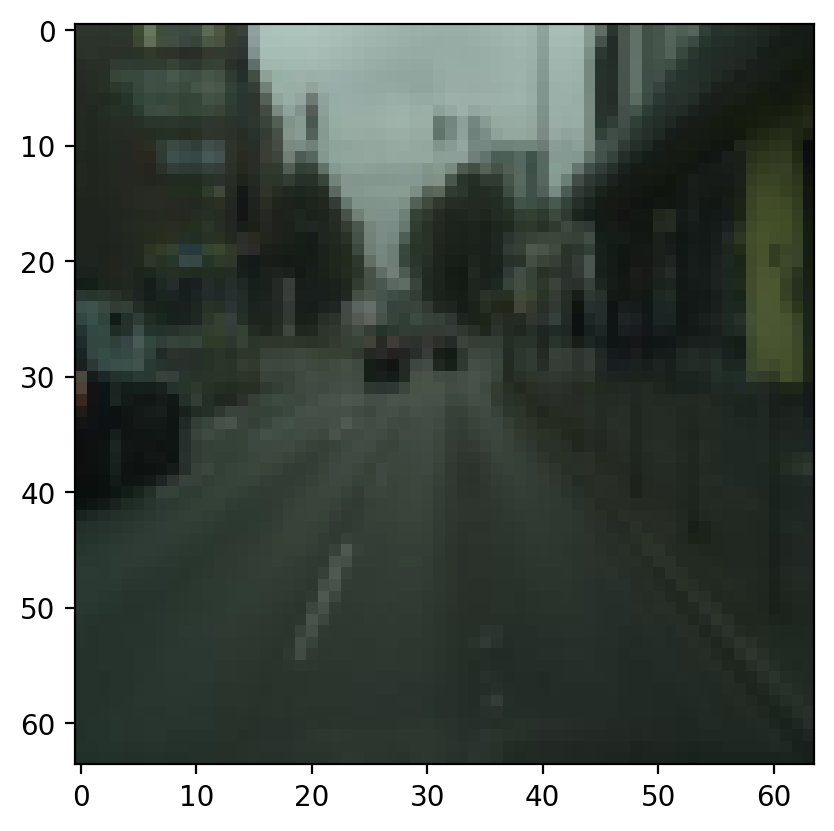

In [15]:
imagen_5_train, label_5_train = dataset_train.__getitem__(5) # Esta es la función que toma la imagen que le indiques, la divbide en imagen y label, aplica las transformaciones...

img_show(imagen_5_train)

Se sigue viendo borrosa ya que, aunque está desnormalizada sigue con el tamaño reducido de 128x128 a 64x64.


One we have defined the Dataset, we can define train and test dataloaders!

Creamos los loaders para entrenamiento, test y validación en batches de 32 imágenes.

La validación tendrá el mismo tamaño que el test (500 imágenes que serán extraidas del conjunto de entrenamiento)

In [16]:
batch_size = 32
valid_size = 500

# Training partition
part_tr = torch.utils.data.random_split(dataset_train, [len(dataset_train)-valid_size, valid_size])[0]
# Use sampler for randomization
training_sampler = torch.utils.data.SubsetRandomSampler(range(len(part_tr)))
# Define the dataloader
trainloader = torch.utils.data.DataLoader(part_tr, batch_size=batch_size, sampler=training_sampler)

# Validation partition
part_val = torch.utils.data.random_split(dataset_train, [valid_size, len(dataset_train)-valid_size])[0]
# Use sampler for randomization
valid_sampler = torch.utils.data.SubsetRandomSampler(range(len(part_val)))
# Define the dataloader
validloader = torch.utils.data.DataLoader(part_val, batch_size=batch_size, sampler=valid_sampler)

# Test partition
# Use sampler for randomization
test_sampler = torch.utils.data.SubsetRandomSampler(range(len(dataset_test)))
# Define the dataloader
testloader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, sampler=test_sampler)


In [17]:
print('TRAIN: ', len(part_tr))
print('VALIDATION: ', len(part_val))
print('TEST: ', len(dataset_test))


TRAIN:  2475
VALIDATION:  500
TEST:  500


# PART III: Define the model

In this lab we are reproducing the following architecture, but for color images (we have a 3 channel image as input).

<figure>
<center><img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png" width="70%"></center> 
<figcaption align = "center"> U-Net architecture. </figcaption>
</figure>


This architecture has 4 main blocks:

*   **Encoder**: The contracting path follows the typical architecture of a convolutional network. It consists of the repeated application of two 3×3 convolutions (padding=1, stride=1), each followed by a rectified linear unit (ReLU) and a 2×2 max pooling operation with stride 2 for downsampling. At each downsampling step we double the number of feature channels.
*   **Bottleneck**: Mid layer that passes the compressed information from the encoder to the decoder.
*   **Decoder**: Every step in the expansive path consists of an upsampling of the feature map followed by a 2×2 convolution (“up-convolution”) (stride = 2, padding = 0) that halves the number of feature channels, a concatenation with the correspondingly cropped feature map from the contracting path, and two 3×3 convolutions, each followed by a ReLU.
*   **Classifier**: Final convolution layer that outputs the segmented image.

The original U-Net does not use batch normalization in between the convolution layer and ReLU. Here we insert batch normalization in between them. It helps the network to reduce internal covariance shift and makes the network more stable while training.



Seguiremos la arquitectura U-Net de la imagen (pero la entrada es de AxBx3 al ser imágenes RGB).

Como vemos, encontramos 4 bloques principales:

    - Encoder: Son 5 capas donde se repiten convoluciones 3x3 con ReLu (con padding and stride de 1) y al final de estas se baja de cada capa con un max pool de 2x2 con stride=2 para reducción del tamaño. Al reducir el tamaño, duplicamos el número de canales.
    - Bottleneck: Capas dentro de la U que envian información de cada capa del encoder a su equivalente en el decoder.
    - Decoder: conv 3x3 y cada paso arriba es una conv 2x2 (con stride = 2 y padding = 0) que divide en 2 el número de canales.
    - Classifier: Conv 1x1 final que da paso al segmentation map.

# Basic blocks
First we implement the basic blocks for this architecture. The first one is the **convolutional block**, which consists of two 3x3 convolutional layers (padding=1, stride=1), each one followed by batch normalization and ReLU activation.

> **Exercise**: complete the following code.

Cada capa (tanto del encoder como del decoder) contará con dos convoluciones seguidas por un Batch Normalization y una f.activación ReLU.

Creemos primero el bloque convolucional que introduciremos en cada capa:

In [18]:
# === CONVOLUTIONAL BLOCK === #
# Two 3x3 convolutional layers, each followed by a batch 
# normalization and a ReLU activation.

class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=in_c, out_channels=out_c, 
                               kernel_size=3, stride=1, padding=1) # stride es el salto del filtro y el padding es rellenar con 0 el borde
        
        self.bn1 = nn.BatchNorm2d(num_features=out_c)

        self.conv2 = nn.Conv2d(in_channels=out_c, out_channels=out_c, 
                               kernel_size=3, stride=1, padding=1) # stride es el salto del filtro y el padding es rellenar con 0 el borde
        
        self.bn2 = nn.BatchNorm2d(num_features=out_c)

        self.relu = nn.ReLU()

    def forward(self, inputs):

        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

Now we define the **encoder block**, which consists of a convolutional block followed by a 2×2 max pooling operation with stride 2 for downsampling. At each downsampling step we double the number of feature channels. 

Note that this block should return the output before and after the downsampling, so we can esily implement the skip connections in the full architecture.

> **Exercise**: complete the following code.

El bloque encoder será usado para aplicar el bloque de 2 convoluciones y bajaremos al siguiente nivel de encoder con un max-pool 2x2 que duplica el número de "feature maps".

In [22]:
# === ENCODER BLOCK === #
# It consists of an conv_block followed by a max pooling.
# Here the number of filters doubles and the height and width half after every block.

class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c) # stride es el salto del filtro y el padding es rellenar con 0 el borde
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, inputs):
      
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

The last basic block we need to implement is the decoder block, which consists of a a 2×2 transpose convolution (“up-convolution”) (stride = 2, padding = 0) that halves the number of feature channels, a concatenation with the correspondingly cropped feature map from the contracting path (**skip connections!**), and a convolutional block.

> **Exercise**: complete the following code.

El decoder en cada capa primero sube al siguiente nivel reduciendo en la mitad los "feature maps" usando una convolución transpuesta y luego, concatenando su información con los valores de la capa equivalente en su cada de encoder, pasa por un bloque de 2 convoluciones completo.

In [21]:
# === DECODER BLOCK === #
# The decoder block begins with a transpose convolution, followed by a concatenation with the skip
# connection from the encoder block. Next comes the conv_block.
# Here the number filters decreases by half and the height and width doubles.

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c,out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(in_c,out_c)

    def forward(self, inputs, skip):
        
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)

        return x

# Full architecture

Now that we have implemented all the basic blocks, we can build our **full U-Net architecture**! 

> **Exercise**: complete the following code.

Dados los bloques de encoder y decoder (apoyados por los bloques de convolución), creamos la arquitectura U-Net vista al principio de este apartado.

U-Net se forma por: 4 capas de encoder, un bottleneck formado por un bloque de convolución donde pasamos del encoder al decoder, 4 capas de decoder y un clasificador final donde ponemos una de las 10 etiquetas posibles a cada píxel de la imágen.

In [29]:
# === FULL ARCHITECTURE === #

class UNet(nn.Module):
    def __init__(self, n_labels):
        super().__init__()

        # ENCODER #
        # in_channels = 3, out_channels=64 for the first block
        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)

        # BOTTLENECK #
        self.b = conv_block(512, 1024)

        # DECODER #
        self.d1 = decoder_block(1024,512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)

        # CLASSIFIER #
        self.outputs = nn.Conv2d(64, n_labels, kernel_size=1, padding=0)

    def forward(self, inputs):

        # NOTATION:
        # s -> skip
        # p -> pooling

        # ENCODER #
        s1, p1 = self.e1.forward(inputs)
        s2, p2 = self.e2.forward(p1)
        s3, p3 = self.e3.forward(p2)
        s4, p4 = self.e4.forward(p3)

        # BOTTLENECK #
        b = self.b.forward(p4)

        # DECODER #
        d1 = self.d1.forward(b, s4)
        d2 = self.d2.forward(d1, s3)
        d3 = self.d3.forward(d2, s2)
        d4 = self.d4.forward(d3, s1)

        # CLASSIFIER #
        outputs = self.outputs(d4)

        return outputs

The following class completes the implementation of the U-Net, extending it with a training method.

> **Exercise**: complete the following code.

Extendemos la clase U-Net para poder entrenarla y evaluar su rendimiento:

In [36]:
class UNet_extended(UNet):

    def __init__(self, n_labels, lr=1e-3,epochs=20):
        
        super().__init__(n_labels)

        # TRAINING VARIABLES
        self.lr = lr    
        self.optim = optim.Adam(self.parameters(), self.lr)   
        self.epochs = epochs

        # CRITERION
        self.criterion = nn.CrossEntropyLoss()

        # LOSS EVOLUTION
        self.loss_during_training = []
        self.valid_loss_during_training = []

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

    def trainloop(self, trainloader, validloader):

        self.train()

        for e in range(int(self.epochs)):

          running_loss = 0.

          for images, labels in trainloader:

            images = images.to(self.device)
            labels = labels.to(self.device)

            self.optim.zero_grad()

            pred = self.forward(images)

            loss = self.criterion(pred, labels)

            loss.backward()

            self.optim.step()

            running_loss += loss.item()

          self.loss_during_training.append(running_loss/len(trainloader))

          # Validation
          # Turn off gradients for validation, saves memory and computations
          with torch.no_grad():            
              
              running_loss = 0.
              
              for images,labels in validloader:

                  images = images.to(self.device)
                  labels = labels.to(self.device)
                  
                  pred = self.forward(images)

                  loss = self.criterion(pred, labels)

                  running_loss += loss.item()   
                  
              self.valid_loss_during_training.append(running_loss/len(validloader))

          print('\nTrain Epoch: {} -> Training Loss: {:.6f}'.format(e,self.loss_during_training[-1]))
          print('Train Epoch: {} -> Validation Loss: {:.6f}'.format(e,self.valid_loss_during_training[-1]))

    def eval_performance(self,dataloader):
        
        loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():

            for images,labels in dataloader:
                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device) 
                probs = self.forward(images)

                labels_pred = torch.argmax(probs, dim=1)
                equals = (labels_pred == labels)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
    
            return accuracy/len(dataloader)

> **Exercise**: Train the model for 30 epochs. Plot the evolution of train and validation losses. Is the network overfitting?



In [37]:
n_epochs = 30
my_UNet = UNet_extended(n_labels=10, epochs= 30)
my_UNet.trainloop(trainloader, validloader)


Train Epoch: 0 -> Training Loss: 0.970806
Train Epoch: 0 -> Validation Loss: 0.667747

Train Epoch: 1 -> Training Loss: 0.624759
Train Epoch: 1 -> Validation Loss: 0.585993

Train Epoch: 2 -> Training Loss: 0.566192
Train Epoch: 2 -> Validation Loss: 0.525225

Train Epoch: 3 -> Training Loss: 0.527590
Train Epoch: 3 -> Validation Loss: 0.497011

Train Epoch: 4 -> Training Loss: 0.491681
Train Epoch: 4 -> Validation Loss: 0.479783

Train Epoch: 5 -> Training Loss: 0.476467
Train Epoch: 5 -> Validation Loss: 0.457404

Train Epoch: 6 -> Training Loss: 0.455363
Train Epoch: 6 -> Validation Loss: 0.421603

Train Epoch: 7 -> Training Loss: 0.435343
Train Epoch: 7 -> Validation Loss: 0.426320

Train Epoch: 8 -> Training Loss: 0.426962
Train Epoch: 8 -> Validation Loss: 0.401784

Train Epoch: 9 -> Training Loss: 0.408642
Train Epoch: 9 -> Validation Loss: 0.395611

Train Epoch: 10 -> Training Loss: 0.407074
Train Epoch: 10 -> Validation Loss: 0.397395

Train Epoch: 11 -> Training Loss: 0.3907

Vemos unos buenos resultados tras el entrenamiento; sin embargo, ploteemos la evolución de la función de entrenamiento y validación a lo largo de las diferentes épocas para asegurar un correcto funcionamiento de la red:

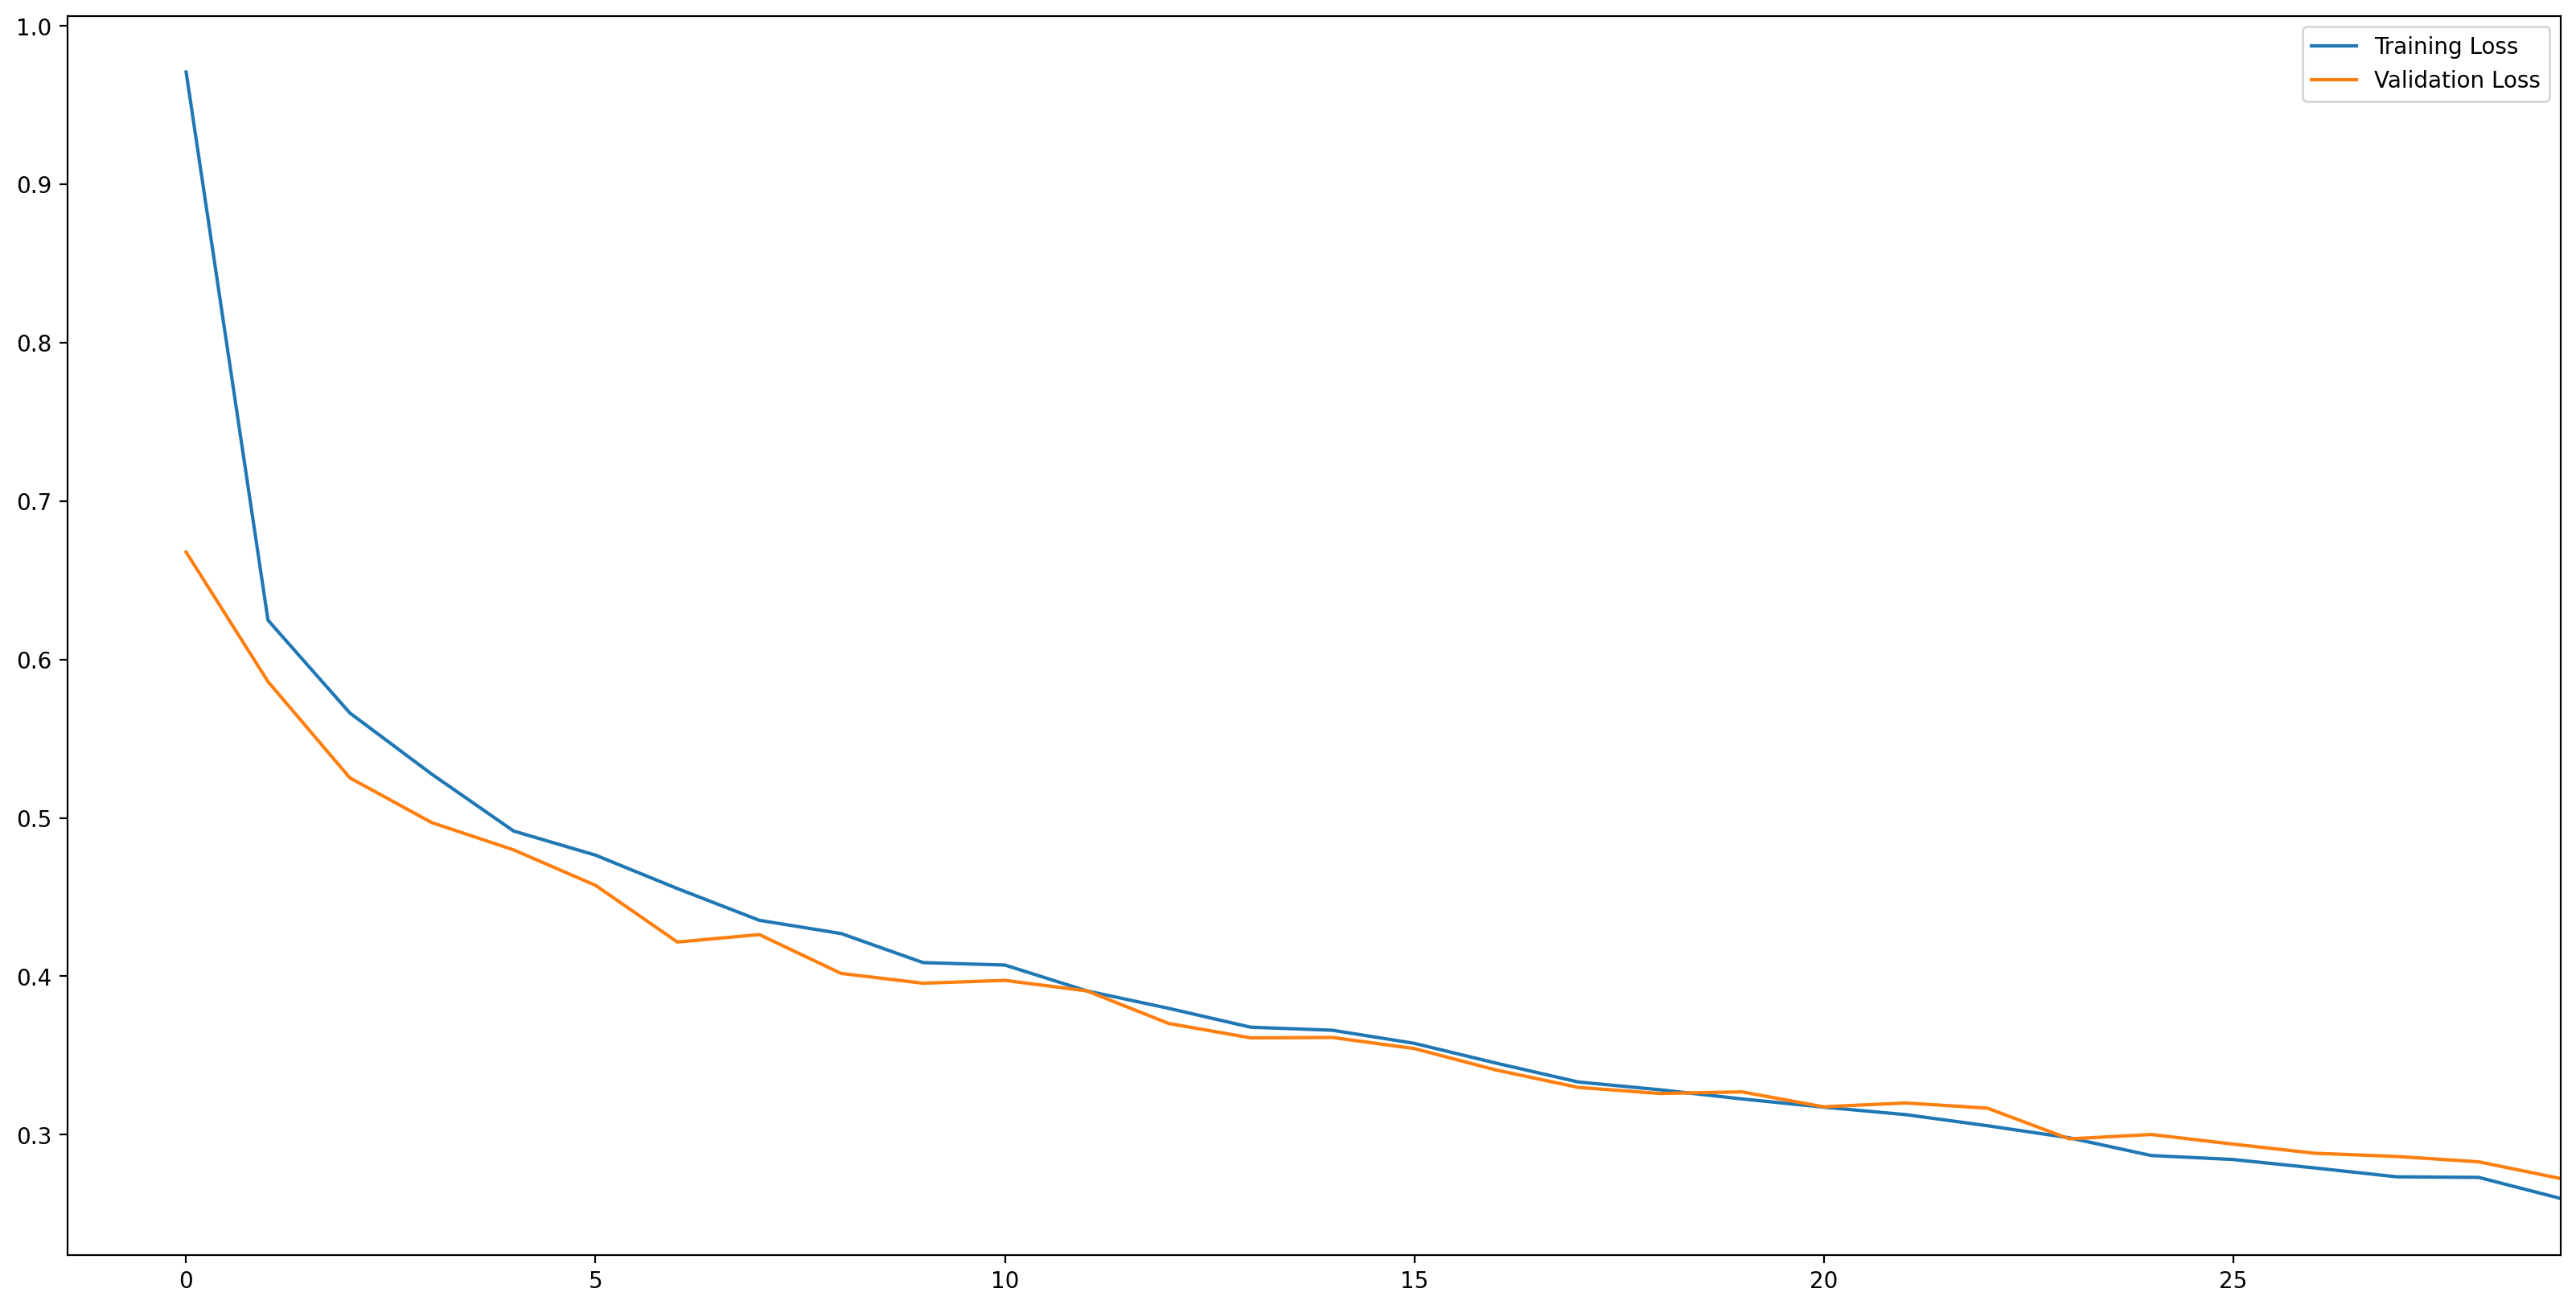

In [39]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(my_UNet.loss_during_training,label='Training Loss')
ax.plot(my_UNet.valid_loss_during_training,label='Validation Loss')
ax.legend()
ax.set_xlim(right=29)
fig.set_facecolor('white')

Vemos un funcionamiento completamente correcto donde ambas funciones decrecen a la par y al final del entrenamiento la "training loss" es menor que la "validation loss" cosa que es lógica y nos da indicios de que, si entrenasemos durante más épocas, tal vez veriamos algo de overfitting (cosa que, en solo 30 épocas, no somos capaces de apreciar).

> **Exercise**: Evaluate the performance of the model in the different data partitions.

In [42]:
# YOUR CODE HERE

print('El accuracy obtenido sobre el conjunto de entrenamiento es de: ' + str(my_UNet.eval_performance(trainloader)) + '%')
print('El accuracy obtenido sobre el conjunto de validación es de: ' + str(my_UNet.eval_performance(validloader)) + '%')
print('El accuracy obtenido sobre el conjunto de test es de: ' + str(my_UNet.eval_performance(testloader)) + '%')

El accuracy obtenido sobre el conjunto de entrenamiento es de: tensor(0.9102)%
El accuracy obtenido sobre el conjunto de validación es de: tensor(0.9039)%
El accuracy obtenido sobre el conjunto de test es de: tensor(0.8572)%


* ERROR: He puesto "%" pero ignorarlo ya que realmente no lo he multiplicado por 100.

Vemos resultados no solo muy coherentes (train mejor que val y mejor que test) sino muy buenos llegando a un 85% en test e incluo un 90% en validation (y encima para un entrenamiento de solo 30 épocas).

> **Exercise**: complete the following code to visualize a prediction. Discuss the obtained results.




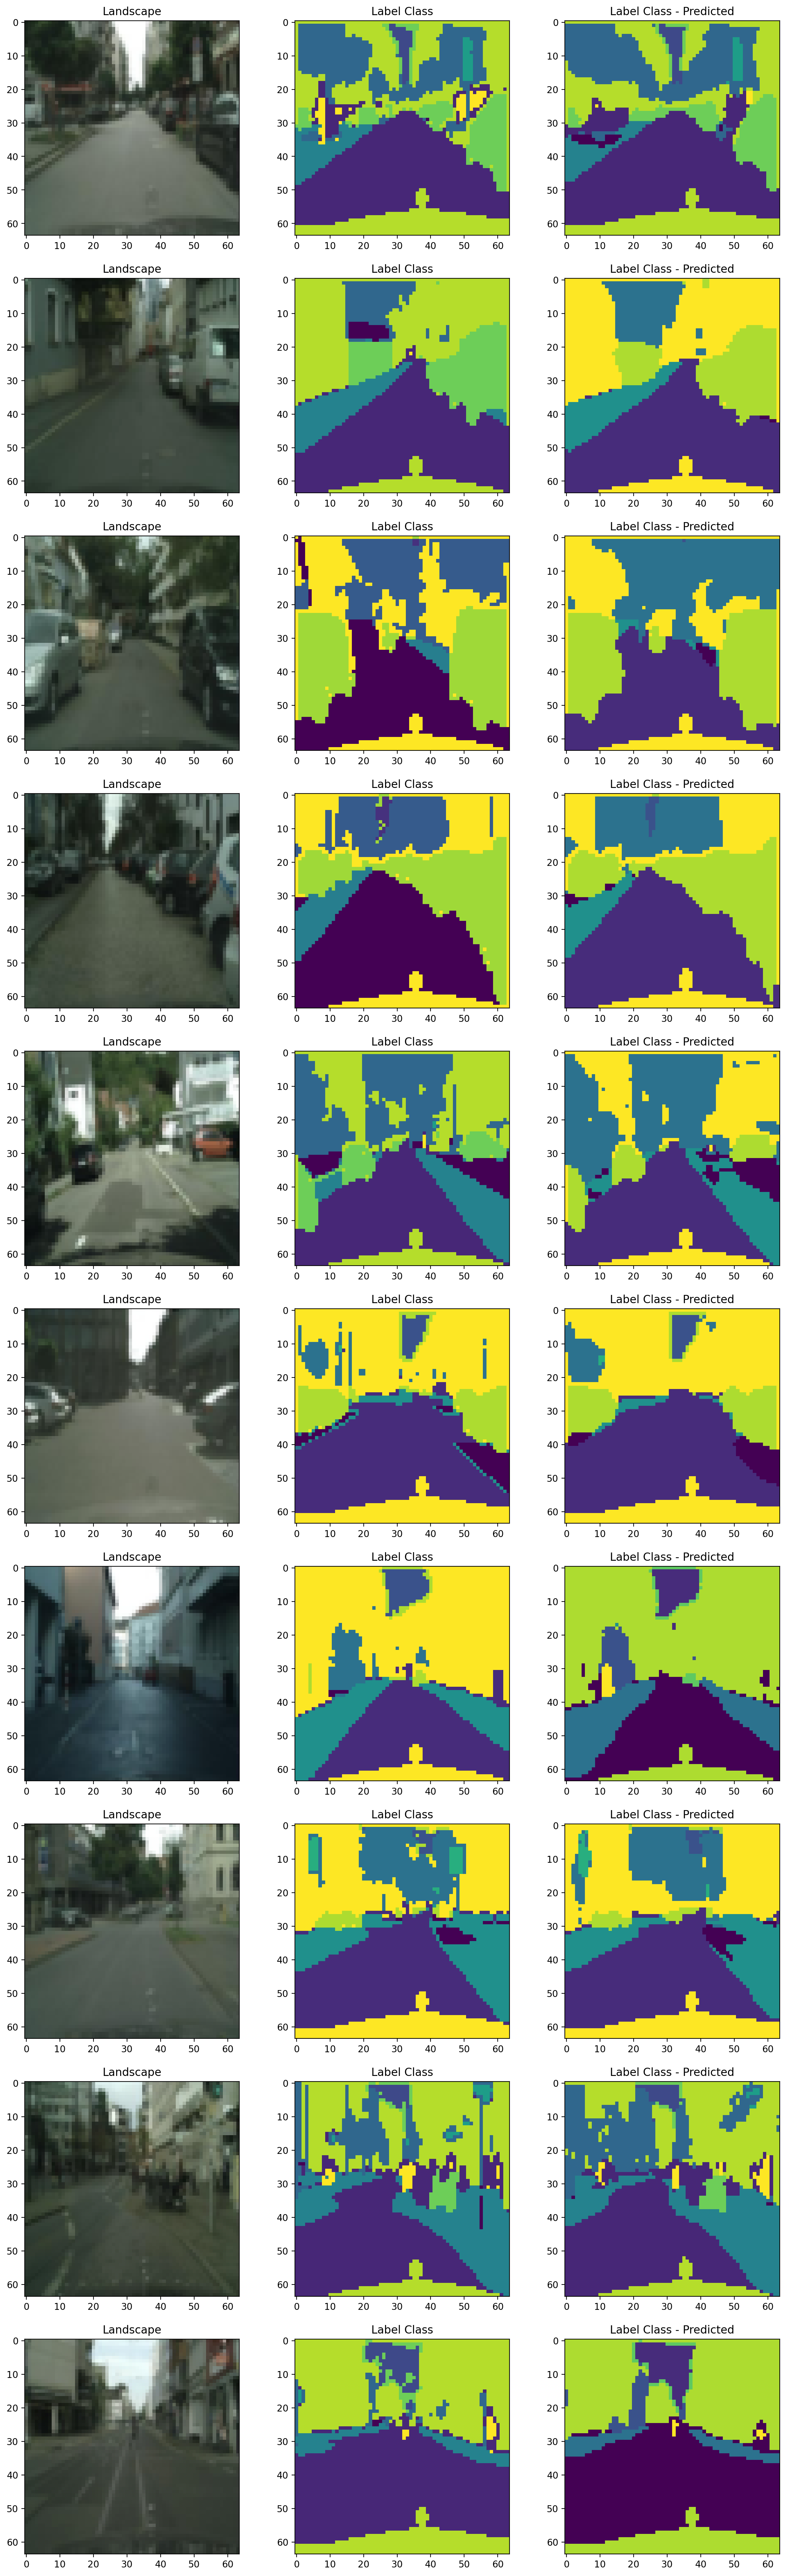

In [95]:
for images, labels in trainloader:
        img = images
        labels = labels

img, labels = img, labels
#img, labels = img.to(my_UNet.device), labels.to(my_UNet.device)

probs = my_UNet.forward(img)

labels_pred = torch.argmax(probs.cpu().detach(), dim=1)

fig, axes = plt.subplots(10, 3, figsize=(3*5, 10*5))

for i in range(10):

    img_plot = np.transpose(img[i,:,:,:].cpu().detach().numpy(), (1, 2, 0))
    img_plot = img_plot / 2 + 0.5

    #labels = np.transpose(labels[i,:,:].cpu().detach().numpy(), (2,0))
    labels = labels / 2 + 0.5

    #labels_pred = np.transpose(labels_pred[i,:,:].cpu().detach().numpy(), (1, 2, 0))
    labels_pred = labels_pred / 2 + 0.5

    axes[i, 0].imshow(img_plot)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(labels[i,:,:])
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(labels_pred[i,:,:])
    axes[i, 2].set_title("Label Class - Predicted")


Vemos unos resultados acordes al buen accuracy obtenido en el ejercicio anterior. Comparador los labels con el segmentation map obtenido por la U-Net vemos que, no solo son MUY parecidos sino que en ciertos casos incluso segmenta de tal manera que devuelve un resultado ciertamente mejor que las propias labels con las que ya contabamos.

(Ignoramos la mala calidad de las imágenes ya que están escaladas a 64x64 para reducir el coste computacional).